In [1]:
import sys
if "../" not in sys.path: sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# import seaborn as sns
# sns.set(rc={'figure.facecolor':'white'})
# plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

from analysis_helpers import savefig, load_data_by_session_id, set_major_minor_ticks, load_additional_data

from eye_tracking.eye_tracking import get_stim_at_frame, get_saccade_magnitude_direction
from experiment.cre_line import match_cre_line
from eye_plotting import STIM_ABBREV, STIM_COLORS

from saccade_config import *

In [2]:
cells = load_additional_data(LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
cells.session_indices = cells.session_indices.apply(eval)
cells.head()

cre_line  cre_abbrev  depth  \
specimen_id                                                                    
589170196    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)  Cux2; Ai93  175.0   
517424547    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)  Cux2; Ai93  175.0   
589170394    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)  Cux2; Ai93  175.0   
589170745    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)  Cux2; Ai93  175.0   
589170856    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)  Cux2; Ai93  175.0   

            targeted_structure  container_id  \
specimen_id                                    
589170196                 VISp   511510718.0   
517424547                 VISp   511510718.0   
589170394                 VISp   511510718.0   
589170745                 VISp   511510718.0   
589170856                 VISp   511510718.0   

                                               session_indices  \
specimen_id                                                      
589170196    ((510174759, 11), (510345479, 67), (510514474,...   
517424547    ((510174759, 109), (510345479, 68), (510514474...   
589170394    ((510174759, 27), (510345479, 205), (510514474...   
589170745    ((510174759, 6), (510345479, 206), (510514474,...   
589170856    ((510174759, 9), (510345479, 22), (510514474, 9))   

             response_classification   p_value  n_left  n_right  \
specimen_id                                                       
589170196                        0.0  0.148500    25.0     36.0   
517424547                        0.0  0.849025    25.0     36.0   
589170394                        0.0  0.994925    25.0     36.0   
589170745                        0.0  0.018600    25.0     36.0   
589170856                        0.0  0.231125    25.0     36.0   

             mean_left_response  mean_right_response  median_left_response  \
specimen_id                                                                  
589170196             -0.005011             0.028588             -0.003895   
517424547             -0.008454            -0.002251             -0.013324   
589170394             -0.084782            -0.060959             -0.033635   
589170745              0.133313             0.303742             -0.005347   
589170856             -0.013324             0.014109             -0.006405   

             median_right_response  direction_selectivity  \
specimen_id                                                 
589170196                -0.000737               1.425049   
517424547                 0.000459              -0.579440   
589170394                 0.006427              -0.163455   
589170745                 0.017718               0.389949   
589170856                 0.009928              34.951378   

             frac_left_significant  frac_right_significant  \
specimen_id                                                  
589170196                     0.20                0.138889   
517424547                     0.20                0.166667   
589170394                     0.20                0.277778   
589170745                     0.24                0.194444   
589170856                     0.24                0.222222   

             wilcoxon_signed_rank_p  ranksum_p_by_direction  
specimen_id                                                  
589170196                  0.378918                0.311603  
517424547                  0.489899                0.472405  
589170394                  0.245655                0.018225  
589170745                  0.301768                0.713904  
589170856                  0.893064                0.012153

In [3]:
def plot_heatmap_responses(data, cell_index, saccades, ax, window_radius=45, colorbar=True, fontsize=14, vmin=None, vmax=None):
    if len(saccades) == 0:
        return

    traces = []

    for ss, se in saccades:
        times = slice(ss-window_radius, ss+window_radius+1)
        trace = data["dff_traces"][cell_index, times]
        if len(trace) == 2*window_radius+1:
            traces.append(trace)
    
    # Color mesh plot
    if vmin is None: vmin = 0
    if vmax is None: vmax = np.percentile(traces, 99)
    cax = ax.pcolormesh(traces, cmap="magma", vmin=vmin, vmax=vmax)
    # if colorbar: cb = fig.colorbar(cax, pad=0.015, label="dF/F")

    set_major_minor_ticks(ax, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell

    # ax.set_xticklabels([ (x-window_radius)/30*1000 if x % 15 == 0 else None for x in xticks], fontsize=14)
    
    # No y-ticks
    # plt.yticks(ticks=[], labels=[])
    # ax.set_yticks([])
    # ax.axis("off")
    # ax.set_title(f"Cell {cell_index}, $p = {p:.4f}$")

    ax.axvline(window_radius+0.5, color="white", linestyle="dashed")

    ax.set_ylabel("Saccade", fontsize=fontsize)
    ax.set_xlabel("Time relative to saccade onset (ms)", fontsize=fontsize)
    # ax.set_title(f"Saccade-triggered {type} averages ({len(cell_mean_traces)} cells, {len(saccades)} saccades)", fontsize=16)
    return vmin, vmax


def plot_saccade_stim_lines(saccades_stim, ax, x, linewidth=3, stim_labels=False):
    ymin = 0
    ymax = None
    for i in range(len(saccades_stim)):
        if i == len(saccades_stim) - 1:
            # This is the last saccade
            ymax = i+1
        elif saccades_stim[i+1][1] != saccades_stim[i][1]:
            # This is the last saccade of the same type as the ones before
            ymax = i+1
        
        if ymax is not None:
            stim = saccades_stim[i][1]
            color = STIM_COLORS[stim]
            ax.vlines(x=x, ymin=ymin, ymax=ymax, color=color, linewidth=linewidth, zorder=10)
            if stim_labels:
                mid = (ymin+ymax)/2
                ax.text(x-1, mid, stim, color=color, ha="right", va="center")
            ymin = ymax
            ymax = None

Session 606227591; Cell 662076627; Ntsr1; Ai148 VISp
Session 606227591; Cell 662076627; Ntsr1; Ai148 VISp


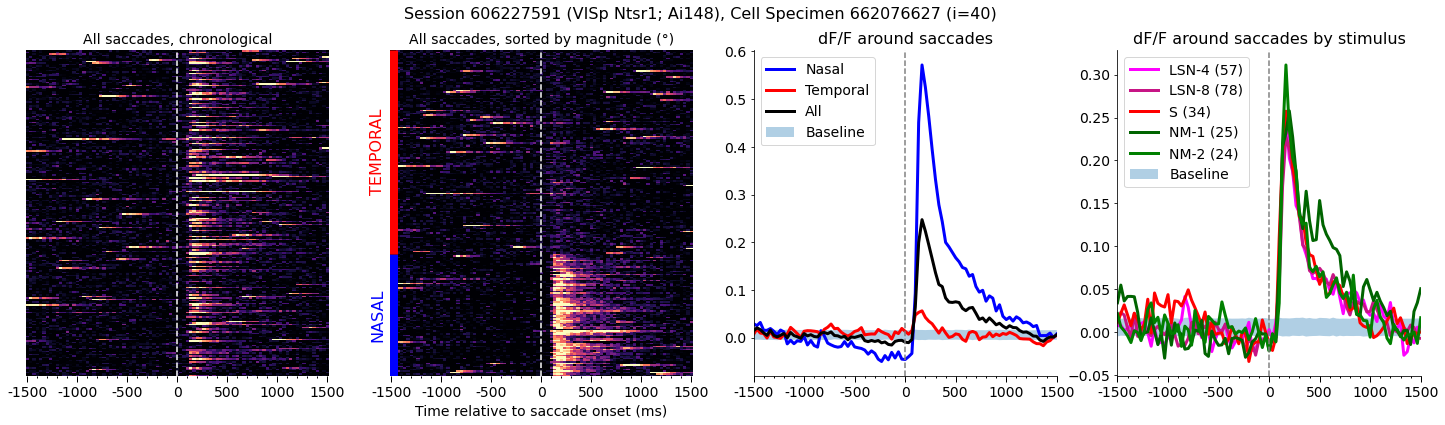

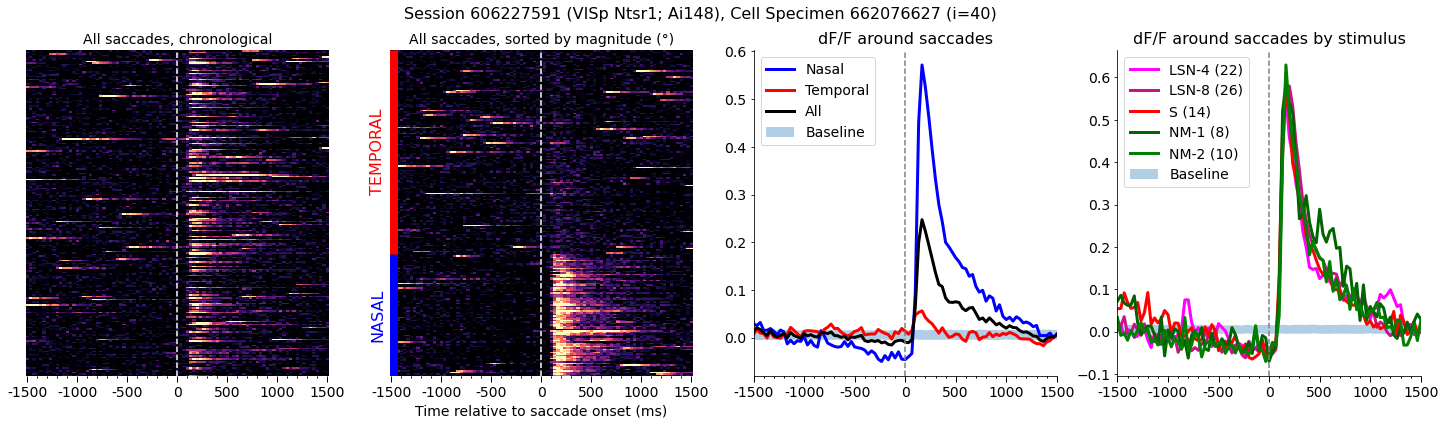

In [74]:
def plot_sample_activity(session_id, cell_index, window_radius=45, response_classification=None, ds=None):
    data = load_data_by_session_id(session_id)
    saccades = data["saccades"]
    eye_data = data["eye_tracking"]
    stim_epoch = data["stim_epoch"]

    fig, (ax_all, ax_sorted, ax_boot, ax_stim) = plt.subplots(ncols=4, figsize=(25, 6), facecolor="white")
    
    # All saccades
    vmin, vmax = plot_heatmap_responses(data, cell_index, list(reversed(saccades)), ax_all, window_radius=window_radius, colorbar=False)
    ax_all.set_title("All saccades, chronological", fontsize=14)
    # plot_saccade_stim_lines(saccades_stim, ax_all, (ax_all.get_xlim()[1]-1)/2)
    ax_all.set_xlabel("")
    ax_all.set_ylabel("")
    ax_all.set_yticks([])
    plt.setp(ax_all.spines.values(), visible=False)

    # Saccades sorted by magnitude
    nasal_sacc = sorted([s for s in saccades if get_saccade_magnitude_direction(eye_data, *s)[1] == "L"], key=lambda s: get_saccade_magnitude_direction(eye_data, *s)[1])
    temporal_sacc = sorted([s for s in saccades if get_saccade_magnitude_direction(eye_data, *s)[1] == "R"], key=lambda s: get_saccade_magnitude_direction(eye_data, *s)[1])
    plot_heatmap_responses(data, cell_index, nasal_sacc + temporal_sacc, ax_sorted, window_radius=window_radius, colorbar=False, vmin=vmin, vmax=vmax)
    xlim = ax_sorted.get_xlim()
    ax_sorted.vlines(x=xlim[0], ymin=0, ymax=len(nasal_sacc), color="blue", linewidth=15)
    ax_sorted.vlines(x=xlim[0], ymin=len(nasal_sacc), ymax=(len(nasal_sacc)+len(temporal_sacc)), color="red", linewidth=15)
    # nasal_label = f"NASAL\n{get_degrees_moved(eye_data, *nasal_sacc[0]):.2f}, {get_degrees_moved(eye_data, *nasal_sacc[len(nasal_sacc)//2]):.2f}, {get_degrees_moved(eye_data, *nasal_sacc[-1]):.2f}"
    # temporal_label = f"TEMPORAL\n{get_degrees_moved(eye_data, *temporal_sacc[0]):.2f}, {get_degrees_moved(eye_data, *temporal_sacc[len(temporal_sacc)//2]):.2f}, {get_degrees_moved(eye_data, *temporal_sacc[-1]):.2f}"
    nasal_label = "NASAL"
    temporal_label = "TEMPORAL"
    ax_sorted.text(xlim[0]-3.5, len(nasal_sacc)/2, nasal_label, fontsize=16, color="blue", ha="center", va="center", rotation=90)
    ax_sorted.text(xlim[0]-3.5, (2*len(nasal_sacc)+len(temporal_sacc))/2, temporal_label, fontsize=16, color="red", ha="center", va="center", rotation=90)
    ax_sorted.set_title("All saccades, sorted by magnitude (°)", fontsize=14)
    ax_sorted.set_ylabel("")
    ax_sorted.set_yticks([])
    ax_sorted.set_xlim(xlim)
    # ax_sorted.yaxis.set_visible(False)
    plt.setp(ax_sorted.spines.values(), visible=False)
    # ax_sorted.spines["left"].set_visible(False)

    # Bootstrapped distribution
    n_bootstrap = 1000
    boot_dist = np.zeros((n_bootstrap, 2*window_radius+1))
    boot_rand_min = boot_dist.shape[1]*5 # int(data["dff"].shape[1] * 0.01)
    boot_rand_max = data["dff_traces"].shape[1] - boot_rand_min

    for b in range(n_bootstrap):
        for i in range(len(saccades)):
            # Choose random saccade time
            ss = random.randint(boot_rand_min, boot_rand_max)
            trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
            boot_dist[b] += trace / len(saccades)

    # n_sacc_boot = 200
    # sacc_boot_dist = np.zeros((n_sacc_boot, 2*window_radius+1))
    # for b in range(n_sacc_boot):
    #     for i in np.random.choice(len(saccades), n_sacc_boot):
    #         ss, se = saccades[i]
    #         trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
    #         sacc_boot_dist[b] += trace / len(saccades)
    
    sacc_responses = []
    dirs = []
    for i, (ss, se) in enumerate(saccades):
        # TODO: validate that it starts when we have times
        trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
        if len(trace) == 2*window_radius+1:
            sacc_responses.append(trace)
            mag, dir = get_saccade_magnitude_direction(eye_data, ss, se)
            dirs.append(dir)
    
    sacc_responses = np.array(sacc_responses)
    
    sacc_mean = sacc_responses.mean(axis=0)
    sacc_mean_nasal = sacc_responses[[i for i in range(len(sacc_responses)) if dirs[i] == "L"], :].mean(axis=0)
    sacc_mean_temporal = sacc_responses[[i for i in range(len(sacc_responses)) if dirs[i] == "R"], :].mean(axis=0)
    mid_95_quantile = [0.025, 0.975] # Middle 95%
    low_q, high_q = np.quantile(boot_dist, mid_95_quantile, axis=0)
    low_q_sacc, high_q_sacc = np.quantile(sacc_responses, mid_95_quantile, axis=0)
    boot_mean = boot_dist.mean(axis=0)

    # print(np.logical_or(np.median(sacc_responses, axis=0) < low_q, high_q < np.median(sacc_responses, axis=0)))

    x = np.arange(-window_radius, window_radius+1)

    set_major_minor_ticks(ax_boot, window_radius, center=0)

    # ax_boot.fill_between(x, *np.quantile(sacc_boot_dist, [0.25, 0.75], axis=0), color="green", alpha=0.35, label="Sacc mid 95%")
    # ax_boot.plot(x, np.mean(sacc_boot_dist, axis=0), color="green", linewidth=2, label="Sacc boot mean")

    # ax_boot.plot(x, boot_mean, label="Boot mean", fontsize=2)
    # ax.fill_between(x, boot_mean-ci_95, boot_mean+ci_95, alpha=0.2, label="Bootstrap 95% CI")
    ax_boot.fill_between(x, low_q, high_q, alpha=0.35, label="Baseline")
    ax_boot.plot(x, sacc_mean_nasal, label="Nasal", color="blue", linewidth=3)
    ax_boot.plot(x, sacc_mean_temporal, label="Temporal", color="red", linewidth=3)
    ax_boot.plot(x, sacc_mean, label="All", color="black", linewidth=3)
    ax_boot.legend(loc="upper left", fontsize=14)
    ax_boot.set_xlim(x[0], x[-1])
    # ax_boot.set_xlabel("Frames relative to saccade onset", fontsize=14)
    ax_boot.set_xlabel("")
    ax_boot.set_ylabel("")
    # ax_boot.set_ylabel("dF/F", fontsize=14)
    ax_boot.set_title("dF/F around saccades", fontsize=16)
    ax_boot.axvline(0, color="gray", linestyle="dashed")
    plt.setp(ax_boot.get_yticklabels(), fontsize=14)
    ax_boot.spines["top"].set_visible(False)
    ax_boot.spines["right"].set_visible(False)


    # By stim type
    traces_by_stim = {}

    for ss, se in saccades:
        stim = get_stim_at_frame(stim_epoch, ss)
        mag, dir = get_saccade_magnitude_direction(eye_data, ss, se)

        if ds is not None:
            if ds == 1 and dir != "R": continue
            elif ds == -1 and dir != "L": continue

        if stim not in traces_by_stim: traces_by_stim[stim] = []
        trace = data["dff_traces"][cell_index, ss-window_radius:ss+window_radius+1]
        traces_by_stim[stim].append(trace)
    
    set_major_minor_ticks(ax_stim, window_radius, center=0)
    ax_stim.fill_between(x, low_q, high_q, alpha=0.35, label="Baseline")
    
    for stim, traces in traces_by_stim.items():
        mean_trace = np.mean(traces, axis=0)

        boot_dist = np.zeros((1000, 2*window_radius+1))
        boot_rand_min = boot_dist.shape[1]*5 # int(data["dff"].shape[1] * 0.01)
        boot_rand_max = data["dff_traces"].shape[1] - boot_rand_min

        for b in range(boot_dist.shape[0]):
            for i in range(len(traces)):
                trace = random.choice(traces)
                boot_dist[b] += trace / len(traces)
        
        color = STIM_COLORS[stim]
        ax_stim.plot(x, mean_trace, color=color, linewidth=3, label=f"{STIM_ABBREV[stim]} ({len(traces)})")
        low_q, high_q = np.quantile(boot_dist, mid_95_quantile, axis=0)
        # ax_stim.fill_between(x, low_q, high_q, color=color, alpha=0.2)

    # ax_stim.legend(loc="upper left", fontsize=14)
    ax_stim.legend(fontsize=14)
    ax_stim.set_xlim(x[0], x[-1])
    ax_stim.set_xlabel("")
    ax_stim.set_ylabel("")
    ax_stim.set_title("dF/F around saccades by stimulus", fontsize=16)
    ax_stim.axvline(0, color="gray", linestyle="dashed")
    plt.setp(ax_stim.get_yticklabels(), fontsize=14)
    ax_stim.spines["top"].set_visible(False)
    ax_stim.spines["right"].set_visible(False)
    


    # Title and save fig
    sdata = data["session_data"]
    area = sdata["targeted_structure"]
    cre = match_cre_line(data).abbrev
    sid = sdata["session_id"]
    specimen = data["cell_specimen_ids"][cell_index]
    fig.suptitle(f"Session {sid} ({area} {cre}), Cell Specimen {specimen} (i={cell_index})", fontsize=16)
    filename = f"cell_responses_{sid}_{cell_index}_{specimen}_{area}_{cre}.png"
    print(f"Session {sid}; Cell {specimen}; {cre} {area}")
    return fig, filename

fig = plot_sample_activity(606227591, 40, ds=None)
fig = plot_sample_activity(606227591, 40, ds=-1)

Session 606227591; Cell 662076627; Ntsr1; Ai148 VISp
Session 662960692; Cell 670074250; Cux2; Ai93 VISrl
Session 506156402; Cell 517476630; Cux2; Ai93 VISal
Session 576373003; Cell 591460874; Sst; Ai148 VISp
Session 636889229; Cell 662209107; Ntsr1; Ai148 VISp
Session 603516552; Cell 662076177; Ntsr1; Ai148 VISp


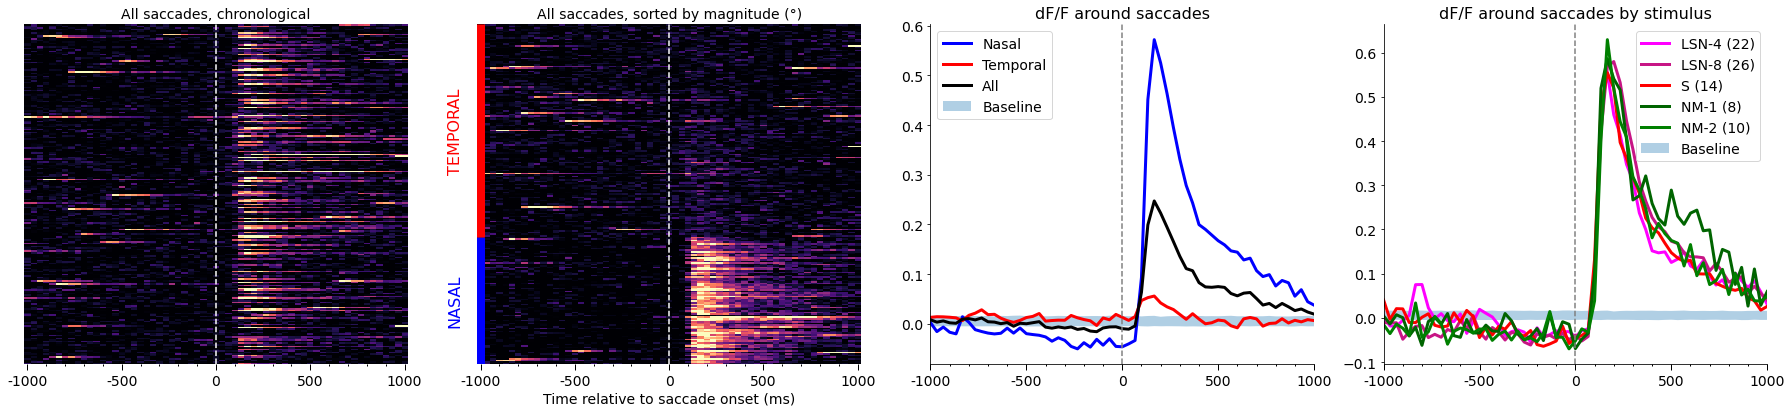

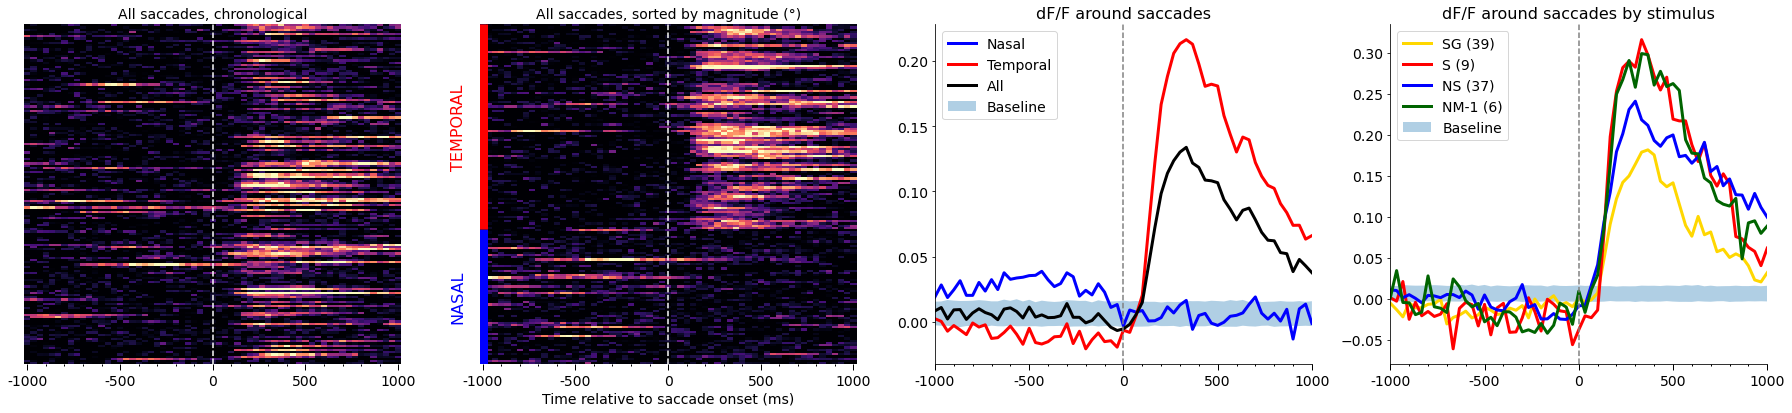

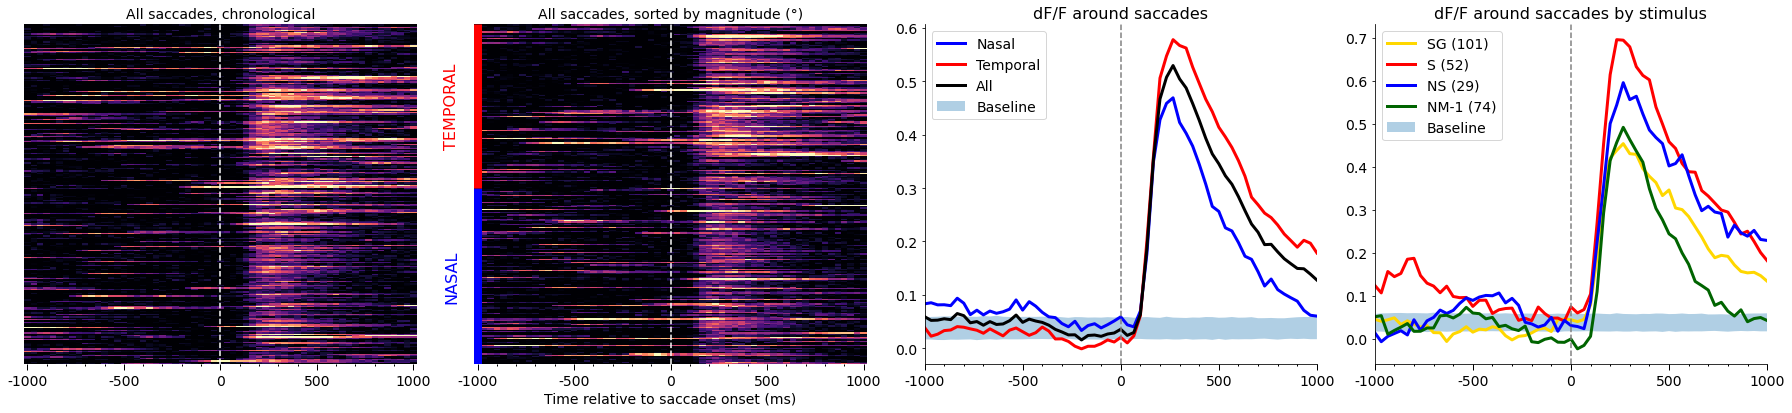

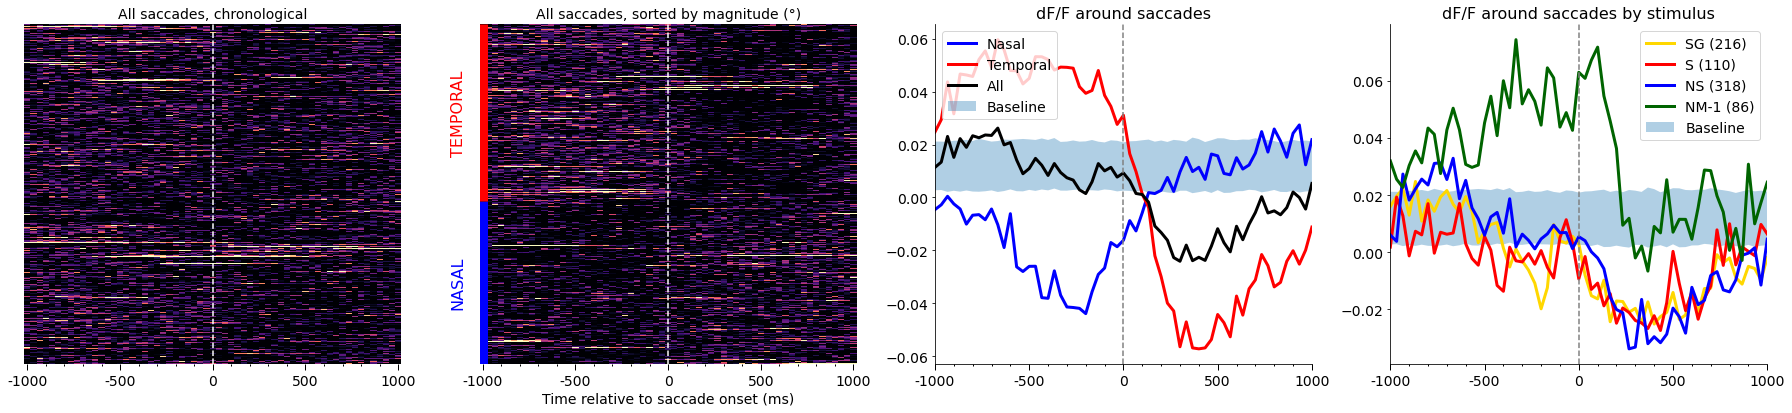

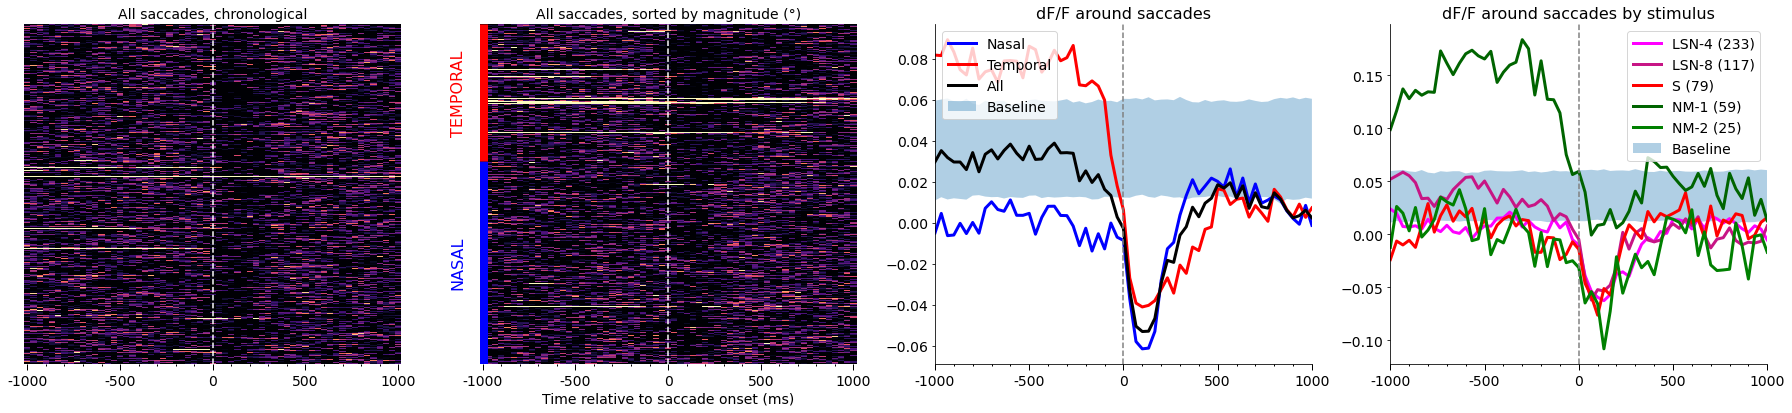

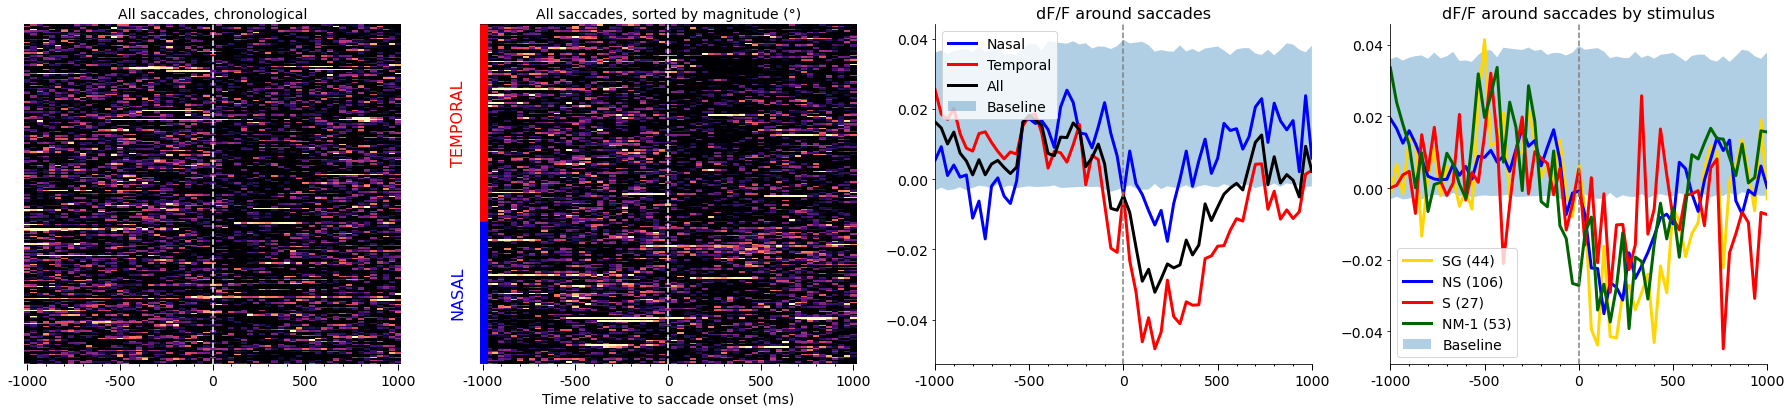

In [78]:
cells_to_plot = [(606227591, 40, 1, -1), (662960692, 73, 1, 1), (506156402, 56, 1, None), (576373003, 1, None, None), (636889229, 5, -1, None), (603516552, 44, -1, None)]

for session_id, cell_index, response_classification, ds in cells_to_plot:
# for session_id, cell_index in ((627823695, 2), (629789161, 6), (636889229, 5)):
    fig, filename = plot_sample_activity(session_id, cell_index, response_classification=response_classification, ds=ds, window_radius=30)
    fig.suptitle("")
    fig.tight_layout()
    savefig(fig, filename, sub_dir="sample_cell_activity")
    # break

In [6]:
is_ds = (cells.response_classification == 1) & (cells.ranksum_p_by_direction < 0.05)
is_L = is_ds & (cells.mean_left_response > cells.mean_right_response)
is_R = is_ds & (cells.mean_left_response < cells.mean_right_response)

is_L.mean(), is_R.mean()

(0.009802108378028482, 0.04521916034769743)

In [7]:
cells.at[cells.index[0], "session_indices"]

((510174759, 11), (510345479, 67), (510514474, 0))

In [8]:
data = load_data_by_session_id(510174759)
data["eye_tracking"][["frame", "eye_area", "pupil_area", "x_pos_deg", "y_pos_deg"]].values

array([[ 0.00000000e+00,  3.12073169e-02,  3.72819547e-03,
        -1.41486739e+01,  2.63233532e+01],
       [ 1.00000000e+00,  3.10436595e-02,  3.70306592e-03,
        -1.40848298e+01,  2.63496031e+01],
       [ 2.00000000e+00,  3.15037682e-02,  3.59283899e-03,
        -1.42206621e+01,  2.64900205e+01],
       ...,
       [ 1.05724000e+05,             nan,             nan,
                    nan,             nan],
       [ 1.05725000e+05,             nan,             nan,
                    nan,             nan],
       [ 1.05726000e+05,             nan,             nan,
                    nan,             nan]])

In [81]:
load_data_by_session_id(658854486)["metadata"]

{'sex': 'male',
 'targeted_structure': 'VISl',
 'ophys_experiment_id': 658854486,
 'experiment_container_id': 657391623,
 'excitation_lambda': '910 nanometers',
 'indicator': 'GCaMP6f',
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Tlx3-Cre_PL56/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt',
 'session_start_time': datetime.datetime(2018, 1, 23, 14, 32, 45),
 'session_type': 'three_session_C2',
 'specimen_name': 'Tlx3-Cre_PL56;Ai148-357093',
 'cre_line': 'Tlx3-Cre_PL56/wt',
 'imaging_depth_um': 375,
 'age_days': 127,
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'pipeline_version': '3.0'}

Session 658854486; Cell 669928467; Tlx3; Ai148 VISl


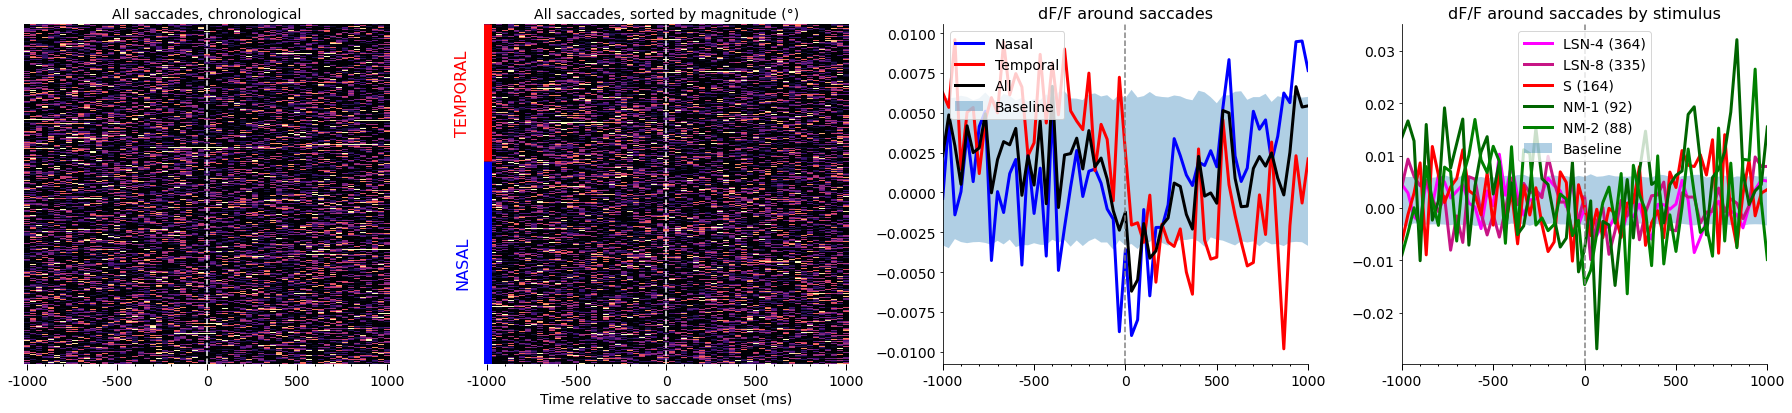

In [83]:
fig, filename = plot_sample_activity(658854486, 156, response_classification=-1, window_radius=30)
fig.suptitle("")
fig.tight_layout()
savefig(fig, filename, sub_dir="sample_cell_activity")

Session 587344053; Cell 591013694; Rorb; Ai93 VISp


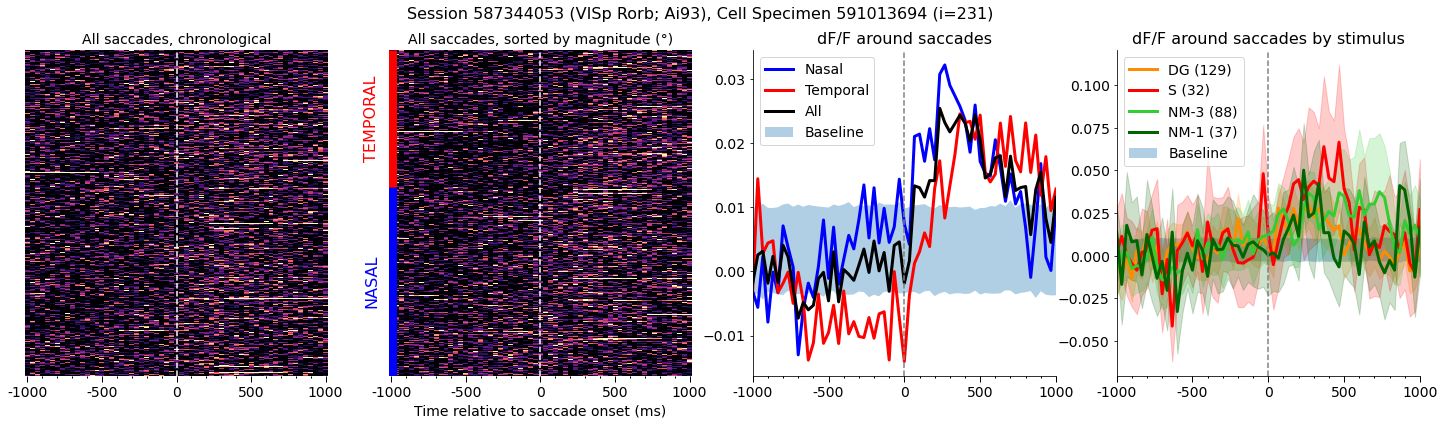

In [9]:
rand_L_cell_idx = np.random.choice(cells.index[is_L])
for session_id, cell_index in cells.at[rand_L_cell_idx, "session_indices"]:
    plot_sample_activity(session_id, cell_index, response_classification=1, ds=-1, window_radius=30)

Session 595273803; Cell 599385497; Rbp4; Ai93 VISam
Session 599125537; Cell 599385497; Rbp4; Ai93 VISam


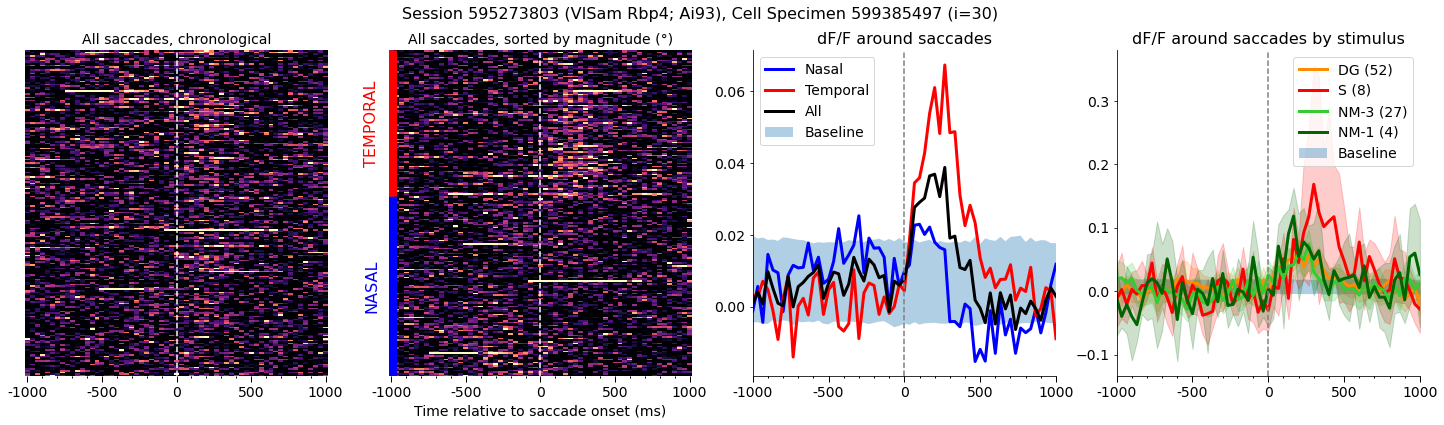

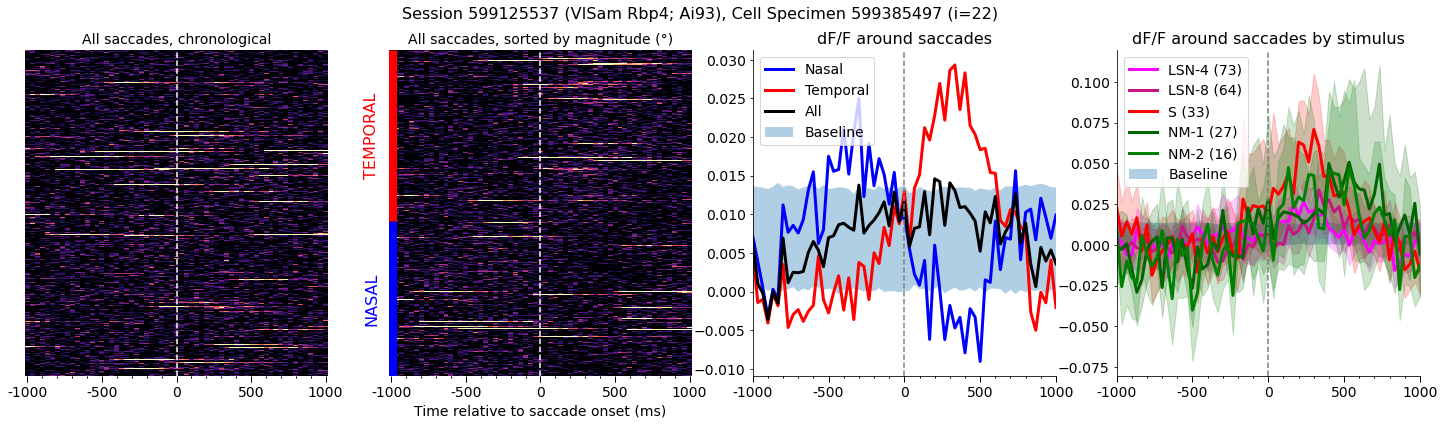

In [10]:

rand_R_cell_idx = np.random.choice(cells.index[is_R])
for session_id, cell_index in cells.at[rand_R_cell_idx, "session_indices"]:
    plot_sample_activity(session_id, cell_index, response_classification=1, ds=1, window_radius=30)

## Example cell that is significantly modulated by saccades but is not flagged by our algorithm

595469327 0.008125 0.003388599428569388 0.03577107513731982
Session 593624660; Cell 595469327; Emx1; Ai93 VISrl


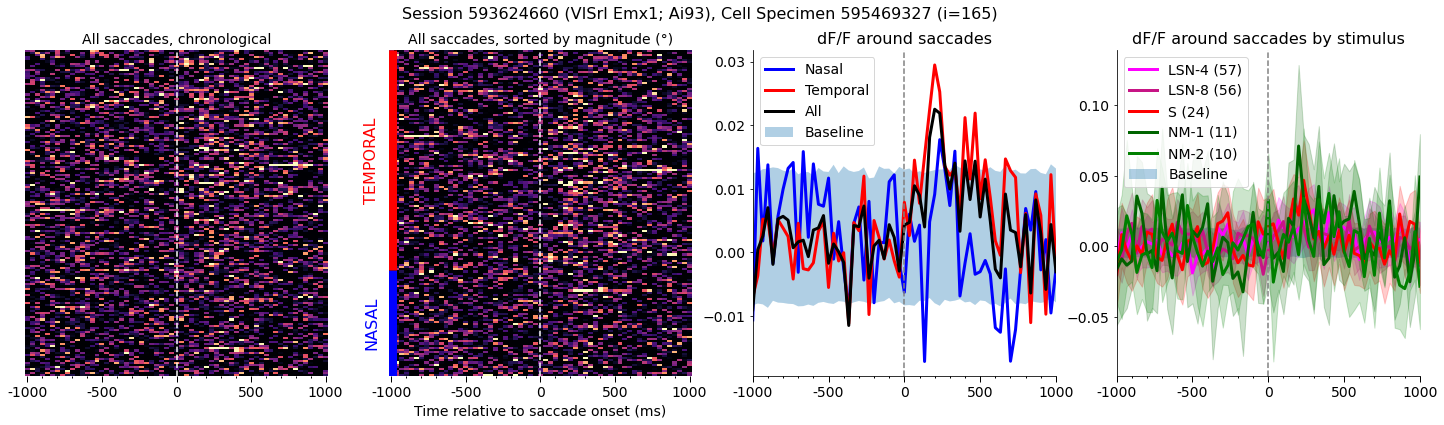

In [63]:
sig_modulated = (cells.wilcoxon_signed_rank_p < 0.05)# | (cells.ranksum_p_by_direction < 0.05)
sig_modulated = (cells.wilcoxon_signed_rank_p < 0.05) & (cells.p_value < 0.05)
not_sr = cells.response_classification == 0
cell = np.random.choice(cells.index[sig_modulated & not_sr])

print(cell, cells.at[cell, "p_value"], cells.at[cell, "wilcoxon_signed_rank_p"], cells.at[cell, "ranksum_p_by_direction"])

for session_id, cell_index in cells.at[cell, "session_indices"]:
    plot_sample_activity(session_id, cell_index, response_classification=0, ds=0, window_radius=30)

In [64]:
cells.columns

Index(['cre_line', 'cre_abbrev', 'depth', 'targeted_structure', 'container_id',
       'session_indices', 'response_classification', 'p_value', 'n_left',
       'n_right', 'mean_left_response', 'mean_right_response',
       'median_left_response', 'median_right_response',
       'direction_selectivity', 'frac_left_significant',
       'frac_right_significant', 'wilcoxon_signed_rank_p',
       'ranksum_p_by_direction'],
      dtype='object')

In [69]:
np.sign(cells[(cells.p_value < 0.05)].direction_selectivity)

specimen_id
589170745    1.0
589170819   -1.0
517425887   -1.0
517427938    1.0
517426476    1.0
            ... 
662075578    1.0
662076134    1.0
662075868   -1.0
688140126   -1.0
688140401   -1.0
Name: direction_selectivity, Length: 10642, dtype: float64

In [70]:
np.sign(cells[(cells.p_value < 0.05)].mean_right_response - cells[(cells.p_value < 0.05)].mean_left_response)

specimen_id
589170745    1.0
589170819   -1.0
517425887   -1.0
517427938    1.0
517426476    1.0
            ... 
662075578    1.0
662076134    1.0
662075868   -1.0
688140126   -1.0
688140401   -1.0
Length: 10642, dtype: float64

In [71]:
ds = np.sign(cells[(cells.p_value < 0.05)].direction_selectivity)
pd.value_counts(ds)

 1.0    7403
-1.0    3239
Name: direction_selectivity, dtype: int64

In [73]:
sig_modulated = (cells.wilcoxon_signed_rank_p < 0.05) | (cells.ranksum_p_by_direction < 0.05)
pd.value_counts(np.sign(cells[sig_modulated].direction_selectivity))

 1.0    13353
-1.0     7276
Name: direction_selectivity, dtype: int64

      fun: 17852
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.05, 0.05])


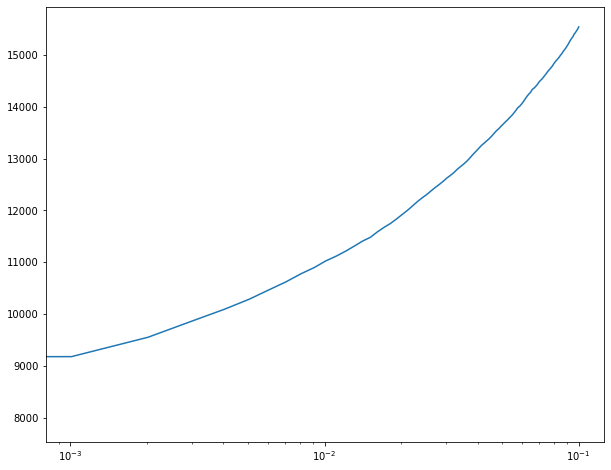

In [37]:
import scipy

def f(x):
    pred = (cells.wilcoxon_signed_rank_p < x[0]) | (cells.ranksum_p_by_direction < x[1])
    actual = cells.response_classification != 0
    # fp = np.count_nonzero(~pred & actual)
    # fn = np.count_nonzero(pred & ~actual)
    # return fp + fn
    return np.count_nonzero(np.logical_xor(pred, actual))

x0 = [0.05, 0.05]
print(scipy.optimize.minimize(f, x0, bounds=((0, 1), (0, 1)), options=dict(maxiter=2000)))

fig, ax = plt.subplots(figsize=(10, 8), facecolor="white")
xx = np.linspace(0, 0.1, 100)
ax.plot(xx, [f([x, 1e-3]) for x in xx])
ax.set_xscale("log")